<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/wandb_efficientdet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [IceVision](https://airctic.com/) meets [W&B](https://wandb.ai/)

IceVision + W&B = Agnostic Object Detection Framework with Outstanding Experiments Tracking 

For more information check the following [Report](https://wandb.ai/ai-fast-track/icevision-fridge/reports/IceVision-meets-W-B--VmlldzoyODQxNjg)

IceVision fully supports W&B by providing a one-liner API that enables users to track their trained models and display both the predicted and ground truth bounding boxes.

W&B makes visualizing and tracking different models performance a highly enjoyable task. Indeed, we are able to monitor the performance of several EfficientDet backbones by changing few lines of code and obtaining very intuitive and easy-to-interpret figures that highlights both the similarities and differences between the different backbones.

In this example, we are using the fastai training loop, it offers a slick integration with wandb through the use of  the `WandbCallback()` callback.


![](https://airctic.github.io/icevision/images/fridge-objects.png)

## Introduction

In this tutorial, we walk you through the different steps of training the fridge dataset. Thanks to W&B, we can easily track the performance of the EfficientDet model using different backbones. In this example, we are using the [fastai](https://github.com/fastai/fastai) library training loop.

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [ ]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!chmod +x install_colab.sh && ./install_colab.sh

## Imports

In [3]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

## Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [ ]:
# Loading Data
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir, force_download=True)

In [ ]:
# Parser
class_map = ClassMap(["milk_bottle", "carton", "can", "water_bottle"])
parser = parsers.voc(annotations_dir=data_dir / "odFridgeObjects/annotations",
                     images_dir=data_dir / "odFridgeObjects/images",
                     class_map=class_map)
# Records
train_records, valid_records = parser.parse()

### Visualization
Showing a batch of images with their corresponding boxes and labels

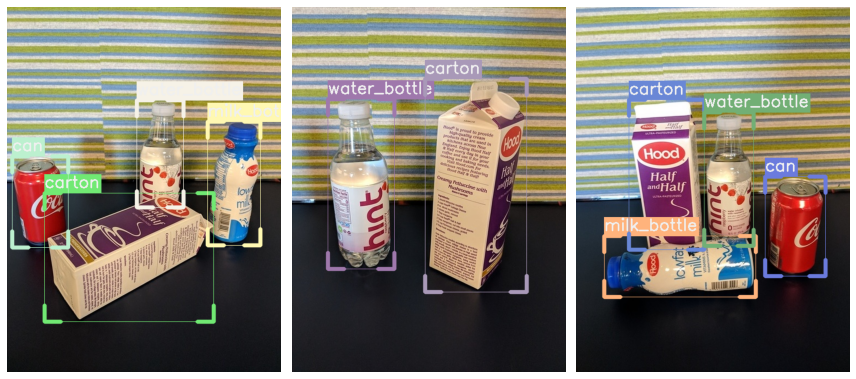

In [6]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Train and Validation Dataset Transforms

In [7]:
# Transforms
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [8]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

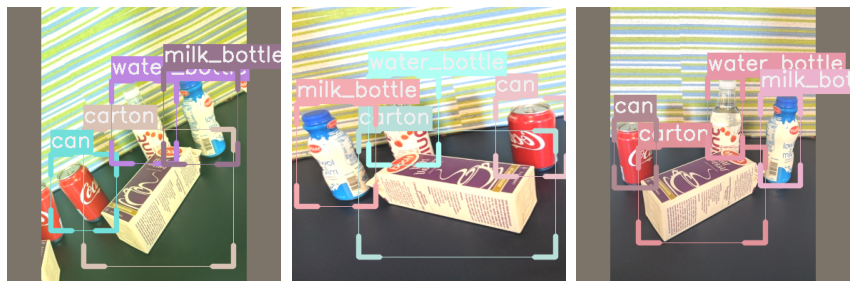

In [9]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map)

## DataLoader

In [10]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

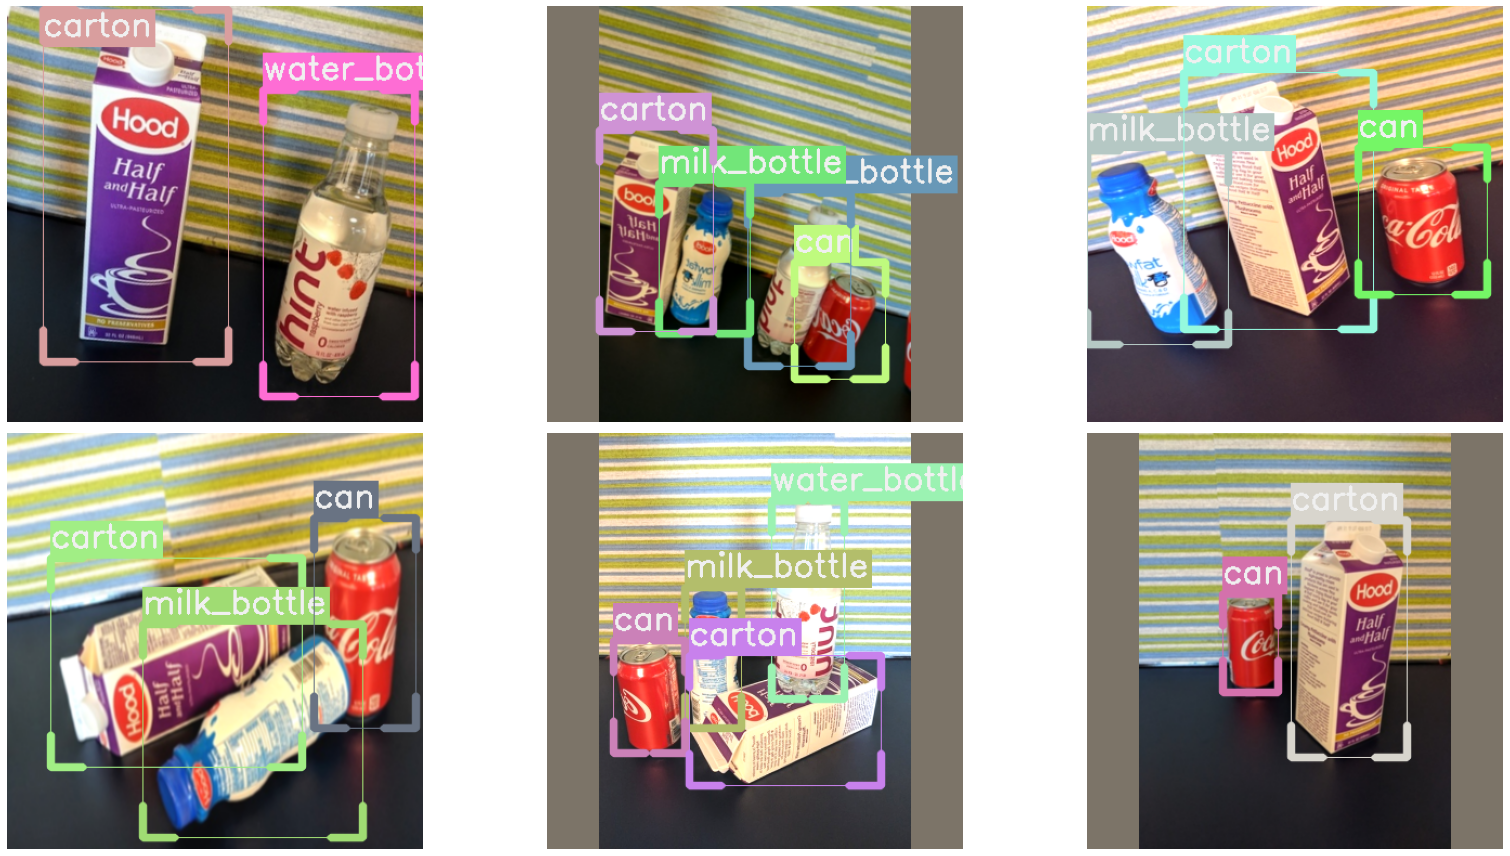

In [11]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=3)

## Model

In [ ]:
# EfficientDet D2 
model = efficientdet.model('tf_efficientdet_d2', num_classes=len(class_map), img_size=384) 

## Metrics

In [13]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [15]:
wandb.init(project="icevision-fridge", name="efficientdet_d2-1", reinit=True)

In [16]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=[WandbCallback(), SaveModelCallback()])

In [ ]:
learn.fine_tune(50, 1e-2, freeze_epochs=5)

## Show results

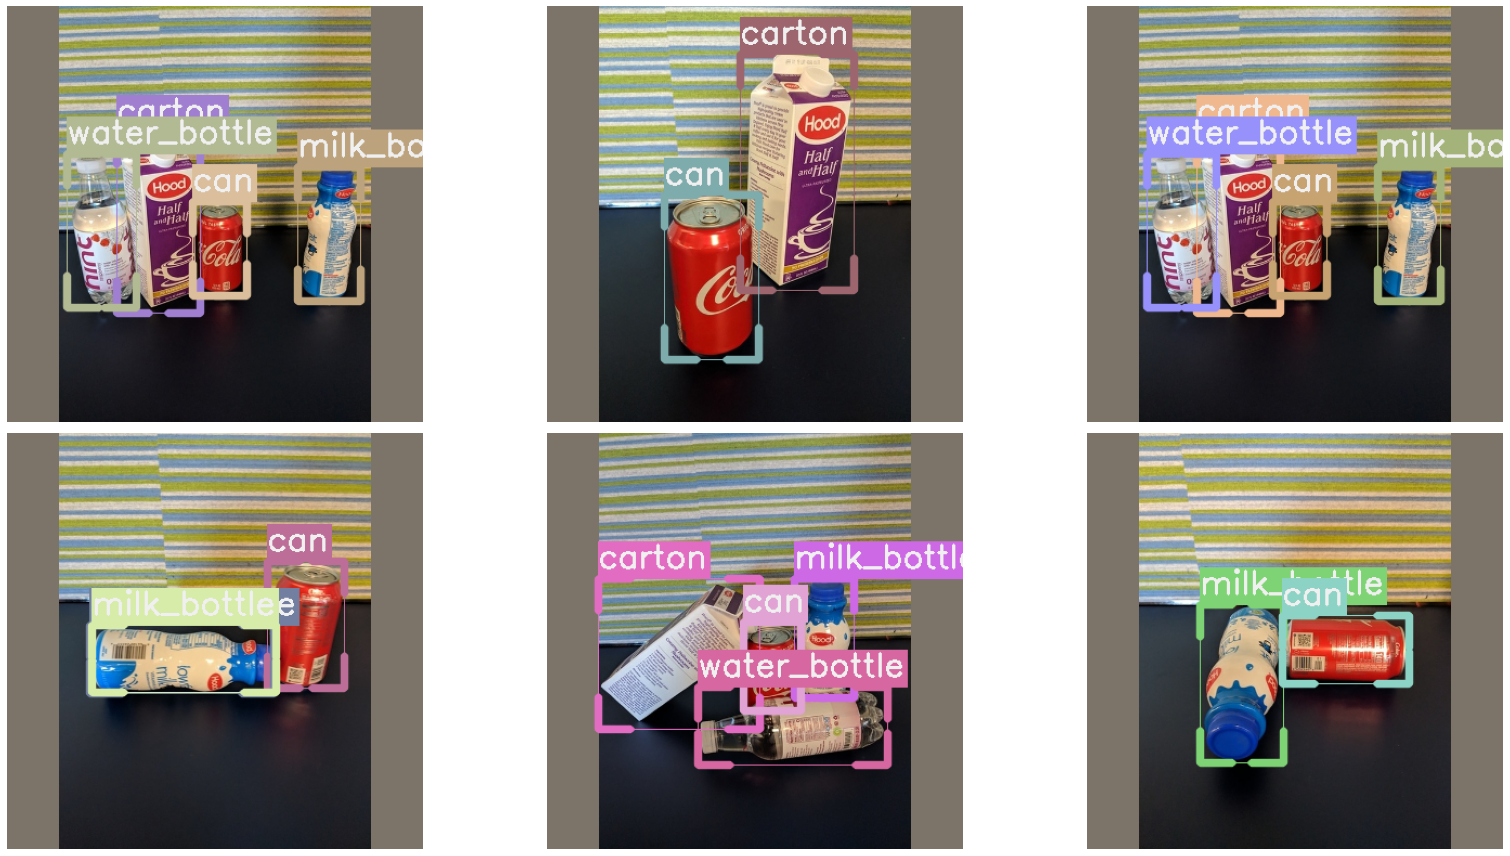

In [18]:
efficientdet.show_results(model, valid_ds, class_map=class_map)

## Inference

In [ ]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=8)
samples, preds = efficientdet.predict_from_dl(model=model, infer_dl=infer_dl)

In [20]:
# from icevision.visualize.wandb_img import *
wandb_images = wandb_img_preds(samples, preds, class_map, add_ground_truth=True) 

In [21]:
wandb.log({"Predicted images": wandb_images})

In [ ]:
# optional: mark the run as completed
wandb.join()

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).